In [1]:
from jax import config; config.update("jax_enable_x64", True)
from jax import numpy as jnp
import numpy as np
from numba import njit

import polars as pl
from polars import col, lit

from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as OLS
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

from plotnine import ggplot
import plotnine as p9


# Import and Split Data
LINK = "http://www.bamlss.org/misc/rent99.raw"
df = pl.read_csv(LINK, separator=" ")
df = df.with_columns(col("yearc").cast(pl.Int32).cast(pl.Utf8).str.to_date(format="%Y")).rename({"yearc": "year"})


y = df["rent"]
X = df.drop("rent")

X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, test_size=2000, random_state=2)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, test_size=1500, random_state=4)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, test_size=500, random_state=42)


In [2]:
from sklearn.base import BaseEstimator
from sklearn.utils import check_X_y,check_array
from scipy.optimize import nnls
from scipy.optimize import minimize
from sklearn.utils.validation import check_is_fitted
# ConstrLS = "Constrained Least Squares" i.e. NNLS.
class ConstrLS(BaseEstimator):
    """
    Constrained least squares, weights sum to 1 and optionally >= 0
    """
    _estimator_type="regressor"
    
    def __init__(self, unit_interval: bool=True):
        self.unit_interval = unit_interval
        
    def fit(self, X, y):
        X,y = check_X_y(X,y, accept_sparse=True)
        xdim = X.shape[1]

        #Use nnls to get initial guess
        coef0, rnorm = nnls(X,y)

        #Define minimisation function
        def fn(coef, X, y):
            return np.linalg.norm(X.dot(coef) - y)
        
        #Constraints and bounds
        cons = {'type': 'eq', 'fun': lambda coef: np.sum(coef)-1}
        if self.unit_interval==True:
            bounds = [[0.0,1.0] for i in range(xdim)] 
        else:
            bounds = None

        #Do minimisation
        fit = minimize(fn,coef0,args=(X, y),method='SLSQP',
                       bounds=bounds,constraints=cons)
        self.coef_ = fit.x
        self.is_fitted_ = True
        self.cvalid=X
        return self
        
    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        return np.matmul(X,self.coef_)



In [3]:
# Stacking Model
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('dt', DecisionTreeRegressor(max_depth=5)),
    ('ols', OLS()),
    ('xgb', XGBRegressor()),
    ('lgbm', LGBMRegressor()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100))),
    ('kr', KernelRidge()),
    ('lasso', LassoCV())
    ]
    

model_stack = StackingRegressor(
    estimators=estimators,
    final_estimator=ConstrLS()
)

model_stack.fit(X_train, y_train)
w = model_stack.final_estimator_.coef_
weights = pl.DataFrame(
    {"estimator": model_stack.named_estimators.keys(),
        'weight': model_stack.final_estimator_.coef_},
    )
print(weights)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 1082, number of used features: 8
[LightGBM] [Info] Start training from score 454.415043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 8
[LightGBM] [Info] Start training from score 453.117474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


shape: (8, 2)
┌───────────┬──────────┐
│ estimator ┆ weight   │
│ ---       ┆ ---      │
│ str       ┆ f64      │
╞═══════════╪══════════╡
│ rf        ┆ 0.257317 │
│ dt        ┆ 0.0      │
│ ols       ┆ 0.069943 │
│ xgb       ┆ 0.54338  │
│ lgbm      ┆ 0.137901 │
│ mlp       ┆ 0.0      │
│ kr        ┆ 0.0      │
│ lasso     ┆ 0.0      │
└───────────┴──────────┘


# Predictions Difference Measure
The distance measure is given by
$$
u(y) = \frac{2}{K(K-1)}\sum_{i=2}^K\sum_{j=1}^{i=1}|y_i - y_j|
$$
for a vector y of length K.

The score is given by:
$$
s(y, \hat{y}, \hat{u}) = \frac{|y - \hat{y}|}{\hat{u}}
$$

The prediction region is given by:
$$
C(x) = [\hat{y}(x) - \hat{u}(x)q_\alpha, \hat{y}(x) + \hat{u}(x)q_\alpha]
$$
where q is the $\alpha$ quantile of the scores.



/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.


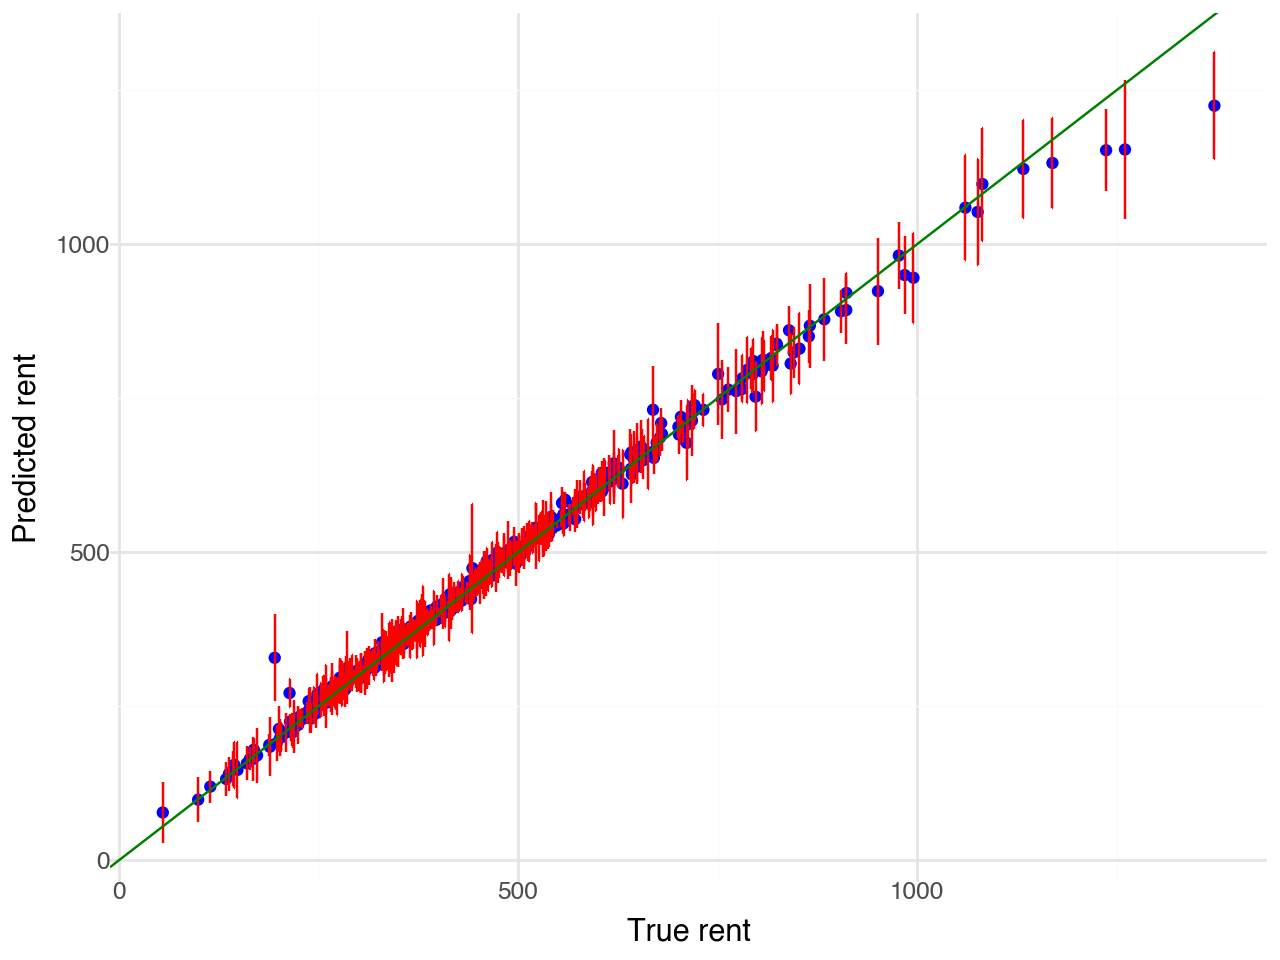

In [12]:
class StackingDistanceMeasure(BaseEstimator):
    _estimator_type="regressor"
    
    def __init__(self, model: StackingRegressor):
        self._model = model
        
    def fit(self, X: np.ndarray | jnp.ndarray, y: np.ndarray | jnp.ndarray):
        try:
            check_is_fitted(self._model, 'estimators_')
            print("Model already fitted")
        except NotFittedError:
            self._model.fit(X, y)
    
    def predict(self, X: np.ndarray | jnp.ndarray) -> np.ndarray:
        # Get individual tree predictions
        all_predictions = np.array([base_model.predict(X) for base_model in self._model.estimators_]).T
        
        @njit
        def compute_pairwise_diff(y):
            K = y.shape[1]
            results = np.zeros(y.shape[0])

            for i in range(y.shape[0]):
                abs_diff_matrix = np.abs(y[i, :, np.newaxis] - y[i, np.newaxis, :])
                sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
                results[i] = (2 / (K * (K - 1))) * sum_abs_diffs

            return results

        @njit
        def compute_dist(y):
            if y.ndim == 1:
                K = len(y)
                abs_diff_matrix = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
                sum_abs_diffs = np.sum(np.tril(abs_diff_matrix, -1))
                result = (2 / (K * (K - 1))) * sum_abs_diffs
                return np.array([result])
            else:
                return compute_pairwise_diff(y)

        return compute_dist(all_predictions)

        
        

class AdaptiveConformalRegression:
    def __init__(self, prediction_fn, var_prediction_fn, alpha=0.05):
        self.prediction_fn = prediction_fn
        self.var_prediction_fn = var_prediction_fn
        self.alpha = alpha
        self.qhat = None

    @staticmethod
    def score_fn(y, y_hat, u_hat):
        return np.abs(y - y_hat) / u_hat

    def fit(self, X_calib, y_calib):
        # Compute y_hat_calib and u_hat_calib using prediction functions
        y_hat_calib = self.prediction_fn.predict(X_calib)
        u_hat_calib = self.var_prediction_fn.predict(X_calib)

        # Compute scores
        scores = np.array([self.score_fn(y, y_hat, u_hat) for y, y_hat, u_hat in zip(y_calib, y_hat_calib, u_hat_calib)])

        # Compute quantile
        self.qhat = np.quantile(scores, 1 - self.alpha)

    def predict_interval(self, X, **kwargs):
        y_hat = self.prediction_fn.predict(X)
        u_hat = self.var_prediction_fn.predict(X, **kwargs) # This is meant to be done using different data than the predict

        # Compute lower and upper bounds
        lower_bound = y_hat - self.qhat * u_hat
        upper_bound = y_hat + self.qhat * u_hat

        return np.array(lower_bound), np.array(upper_bound)

dist_measure = StackingDistanceMeasure(model_stack)

adaptive_conformal = AdaptiveConformalRegression(model_stack, dist_measure)

adaptive_conformal.fit(X_calib, y_calib)

y_pred = model_stack.predict(X_new)

lower, upper = adaptive_conformal.predict_interval(X_new)


coverage_dist = regression_coverage_score(y_new, lower, upper)
mean_width_dist = regression_mean_width_score(lower, upper)

df_plot = pl.DataFrame({
    "rent": y_new,
    "rent_pred": y_pred,
    "lower": lower,
    "upper": upper
}).to_pandas()

(    
ggplot(df_plot) +
    p9.geom_point(p9.aes(x="rent", y="rent_pred"), color="blue") +
    p9.geom_errorbar(p9.aes(x="rent", ymin="lower", ymax="upper"), color="red") +
    p9.geom_abline(intercept=0, slope=1, color="green") +
    p9.labs(x="True rent", y="Predicted rent") +
    p9.theme_minimal()
)

# Stacking Variance
The uncertainty measure is given by the variance of the predictions of the base models. The variance is given by
$$
u(y) = \frac{1}{K}\sum_{i=1}^K(y_i - \bar{y})^2
$$
for a vector of predictions y of length K.

The score and prediction region are the same as the distance measure.

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.


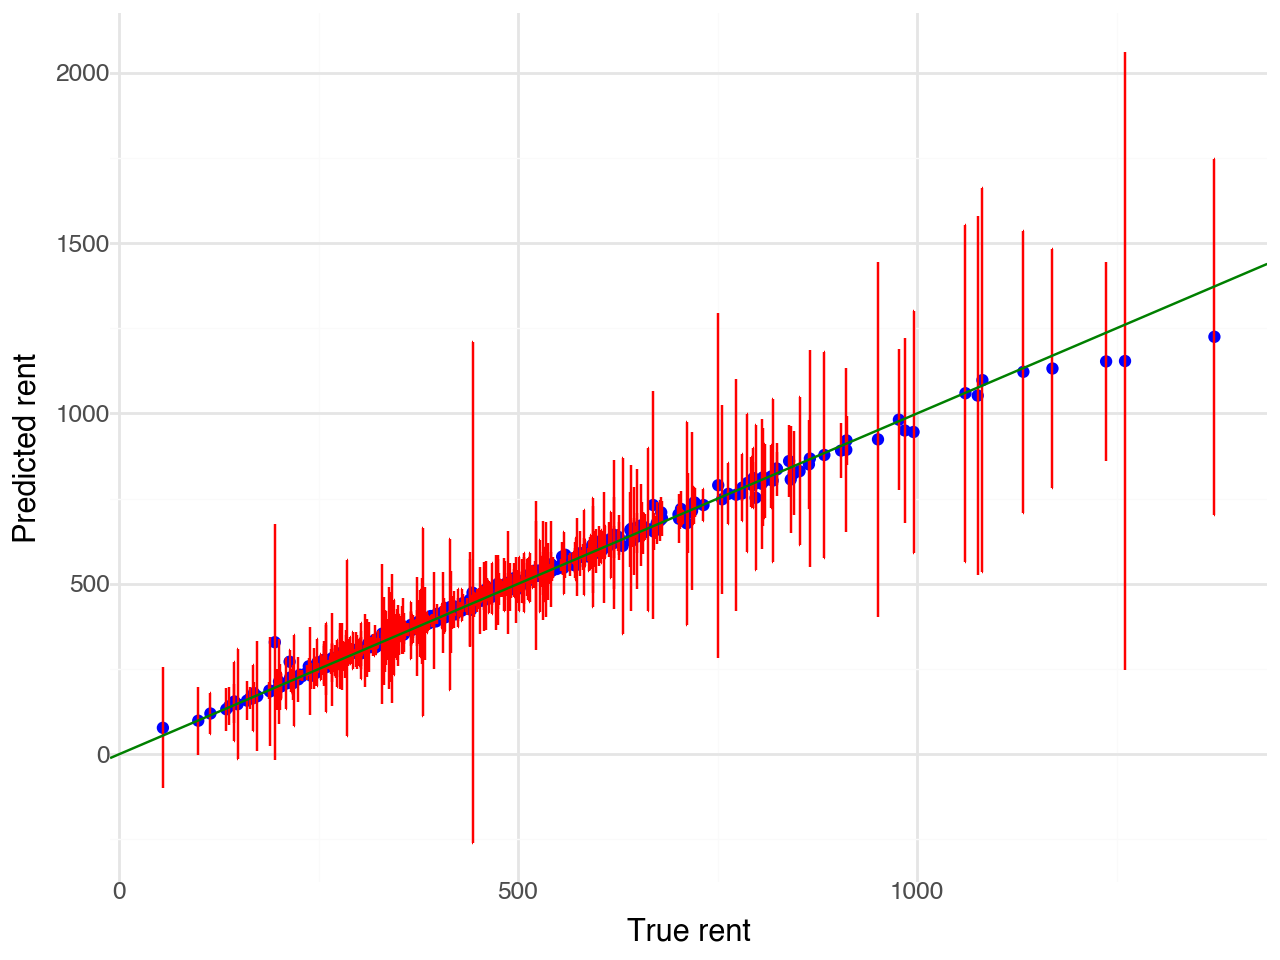

In [14]:
class StackingVarianceMeasure(BaseEstimator):
    _estimator_type="regressor"
    
    def __init__(self, model: StackingRegressor):
        self._model = model
        
    def fit(self, X: np.ndarray | jnp.ndarray, y: np.ndarray | jnp.ndarray):
        try:
            check_is_fitted(self._model, 'estimators_')
            print("Model already fitted")
        except NotFittedError:
            self._model.fit(X, y)
    
    def predict(self, X: np.ndarray | jnp.ndarray) -> np.ndarray:
        # Get individual tree predictions
        all_predictions = np.array([base_model.predict(X) for base_model in self._model.estimators_]).T

        
        variance_predictions = np.var(all_predictions, axis=1)
        return variance_predictions
    
var_measure = StackingVarianceMeasure(model_stack)

adaptive_conformal_var = AdaptiveConformalRegression(model_stack, var_measure)

adaptive_conformal_var.fit(X_calib, y_calib)

y_pred = model_stack.predict(X_new)

lower, upper = adaptive_conformal_var.predict_interval(X_new)

coverage_var = regression_coverage_score(y_new, lower, upper)
mean_width_var = regression_mean_width_score(lower, upper)

df_plot = pl.DataFrame({
    "rent": y_new,
    "rent_pred": y_pred,
    "lower": lower,
    "upper": upper
}).to_pandas()
(
ggplot(df_plot) +
    p9.geom_point(p9.aes(x="rent", y="rent_pred"), color="blue") +
    p9.geom_errorbar(p9.aes(x="rent", ymin="lower", ymax="upper"), color="red") +
    p9.geom_abline(intercept=0, slope=1, color="green") +
    p9.labs(x="True rent", y="Predicted rent") +
    p9.theme_minimal()
)


# Conformalized quantile regression
Note: This does not work with StackRegressor.


In [6]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, KFold
estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    verbose=-1
)
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=100),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=10,
    cv=KFold(n_splits=5, shuffle=True),
)
optim_model.fit(X_train, y_train)
estimator = optim_model.best_estimator_


In [15]:
from mapie.regression import MapieQuantileRegressor, MapieRegressor


mapie = MapieQuantileRegressor(estimator, cv="split", alpha=0.05)
mapie.fit(
    X_train, y_train,
    X_calib=X_calib, y_calib=y_calib,
)

point, conf = mapie.predict(X_new)
lower, upper = conf[:, 0], conf[:, 1]

coverage_quantile = regression_coverage_score(y_new, lower, upper)
mean_width_quantile = regression_mean_width_score(lower, upper)

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.


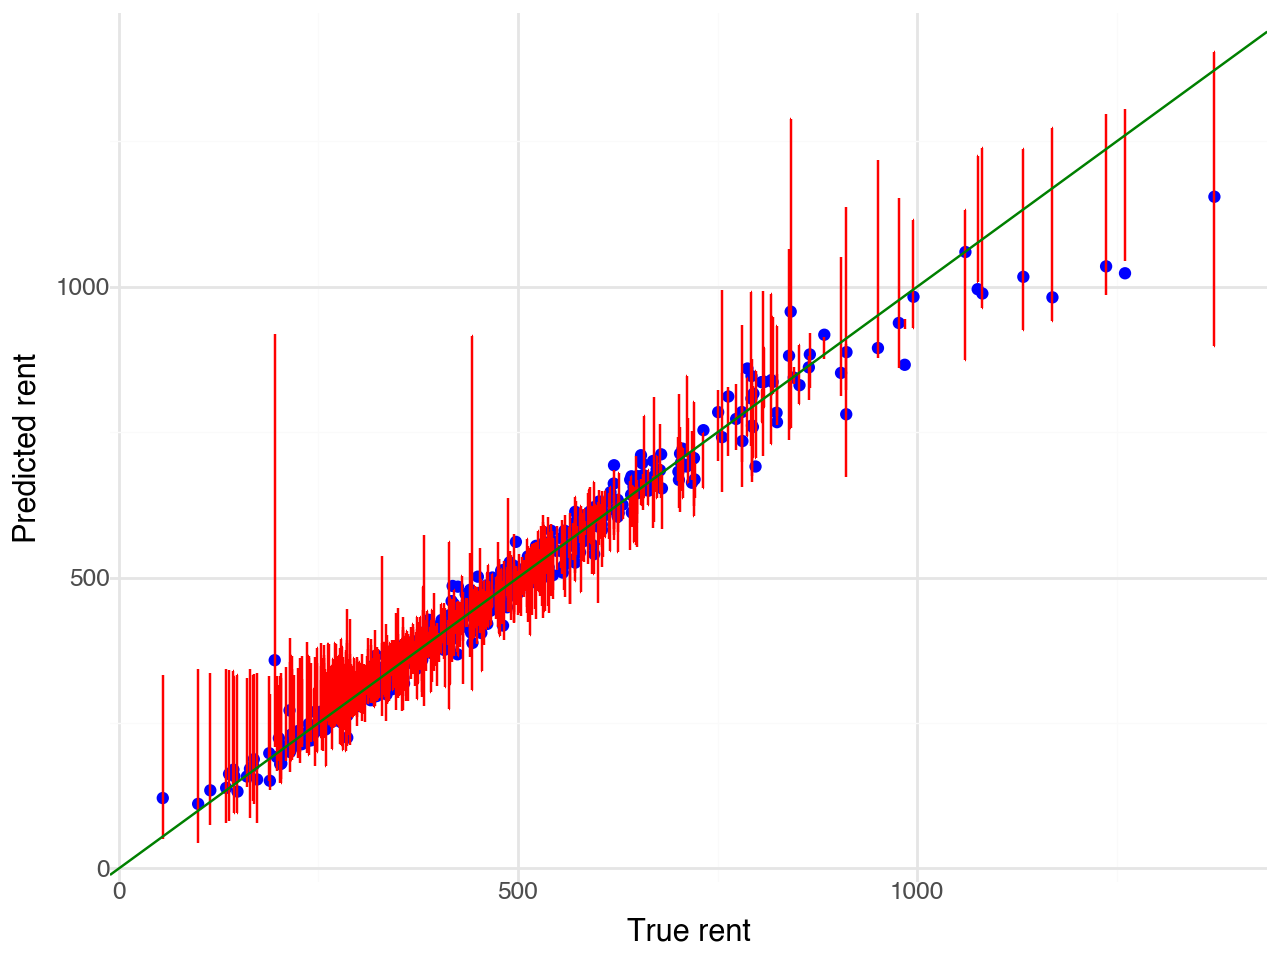

In [8]:
df_plot = pl.DataFrame({
    "rent": y_new,
    "rent_pred": point,
    "lower": lower,
    "upper": upper
}).to_pandas()

df_plot["lower"] = df_plot["lower"].apply(lambda x: x[0])
df_plot["upper"] = df_plot["upper"].apply(lambda x: x[0])

(
ggplot(df_plot) +
    p9.geom_point(p9.aes(x="rent", y="rent_pred"), color="blue") +
    p9.geom_errorbar(p9.aes(x="rent", ymin="lower", ymax="upper"), color="red") +
    p9.geom_abline(intercept=0, slope=1, color="green") +
    p9.labs(x="True rent", y="Predicted rent") +
    p9.theme_minimal()
)
# df_plot

# Basic Conformal Prediction


In [9]:
from mapie.regression import MapieRegressor

conformal = MapieRegressor(model_stack, cv="split")
conformal.fit(
    X_train, y_train,
)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 1082, number of used features: 8
[LightGBM] [Info] Start training from score 454.415043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 8
[LightGBM] [Info] Start training from score 453.117474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:565: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice


MapieRegressor(cv='split',
               estimator=StackingRegressor(estimators=[('rf',
                                                        RandomForestRegressor()),
                                                       ('dt',
                                                        DecisionTreeRegressor(max_depth=5)),
                                                       ('ols',
                                                        LinearRegression()),
                                                       ('xgb',
                                                        XGBRegressor(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     device=None,
                                                                     early_stopping_rounds=None,
                                                                     enable_categor...
                                                                     max_delta_step=None,
                                                                     max_depth=None,
                                                                     max_leaves=None,
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     random_state=None, ...)),
                                                       ('lgbm',
                                                        LGBMRegressor()),
                                                       ('mlp',
                                                        MLPRegressor(hidden_layer_sizes=(100,
                                                                                         100))),
                                                       ('kr', KernelRidge()),
                                                       ('lasso', LassoCV())],
                                           final_estimator=ConstrLS()),
               method='base')

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/mapie/utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.


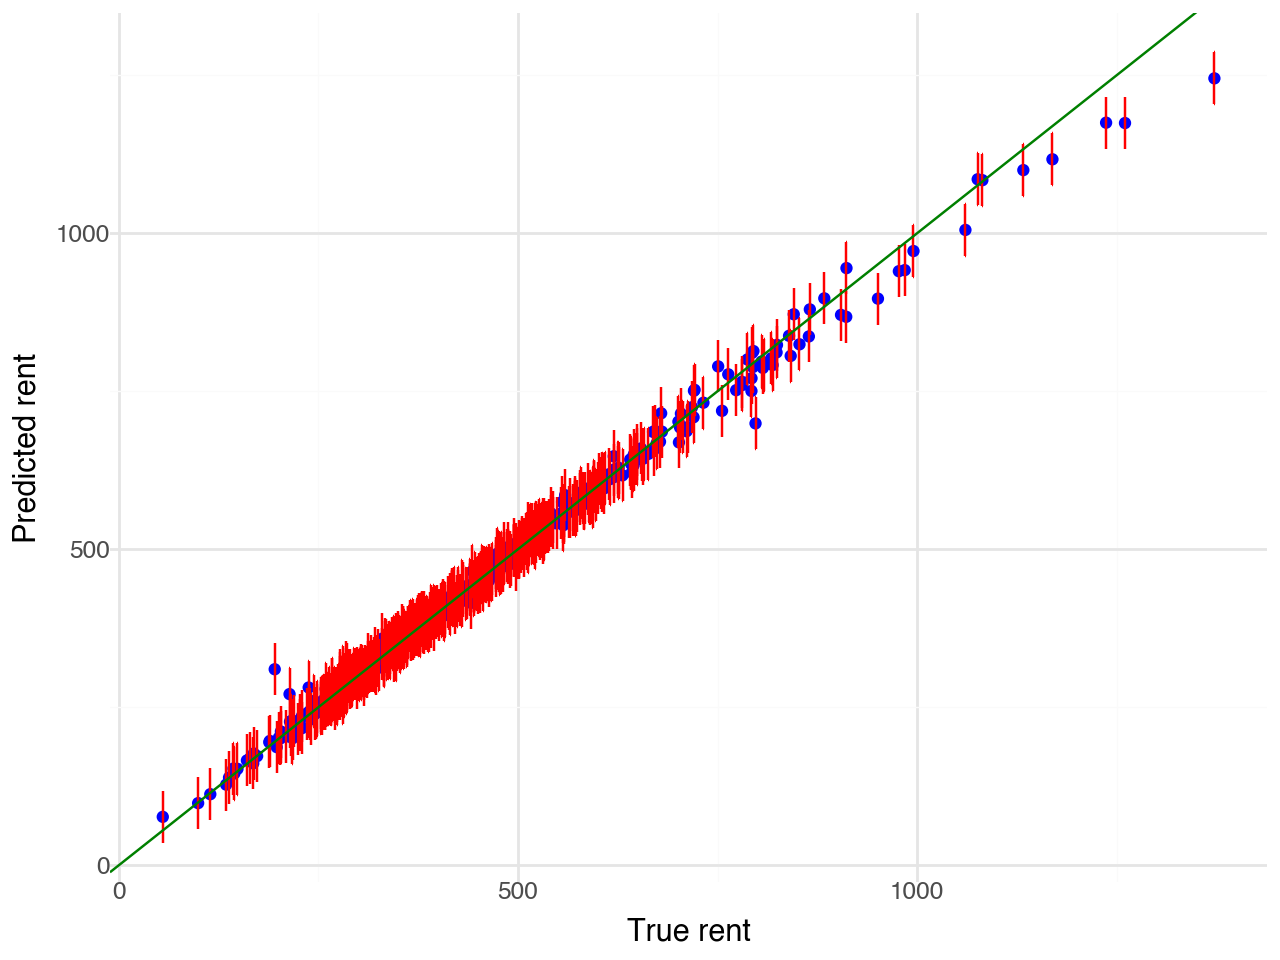

In [17]:
point, conf = conformal.predict(X_new, alpha=0.05)
lower, upper = conf[:, 0], conf[:, 1]

coverage_basic = regression_coverage_score(y_new, lower, upper)
mean_width_basic = regression_mean_width_score(lower, upper)

df_plot = pl.DataFrame({
    "rent": y_new,
    "rent_pred": point,
    "lower": lower,
    "upper": upper
}).to_pandas()

df_plot["lower"] = df_plot["lower"].apply(lambda x: x[0])
df_plot["upper"] = df_plot["upper"].apply(lambda x: x[0])

(
ggplot(df_plot) +
    p9.geom_point(p9.aes(x="rent", y="rent_pred"), color="blue") +
    p9.geom_errorbar(p9.aes(x="rent", ymin="lower", ymax="upper"), color="red") +
    p9.geom_abline(intercept=0, slope=1, color="green") +
    p9.labs(x="True rent", y="Predicted rent") +
    p9.theme_minimal()
)

# Comparison 


In [18]:
df_results = pl.DataFrame({
    "Method": ["Distance", "Variance", "Quantile", "Basic"],
    "Coverage": [coverage_dist, coverage_var, coverage_quantile, coverage_basic],
    "Mean Width": [mean_width_dist, mean_width_var, mean_width_quantile, mean_width_basic]
})
print(df_results)

shape: (4, 3)
┌──────────┬──────────┬────────────┐
│ Method   ┆ Coverage ┆ Mean Width │
│ ---      ┆ ---      ┆ ---        │
│ str      ┆ f64      ┆ f64        │
╞══════════╪══════════╪════════════╡
│ Distance ┆ 0.942    ┆ 52.046058  │
│ Variance ┆ 0.96     ┆ 134.039079 │
│ Quantile ┆ 0.968    ┆ 106.494772 │
│ Basic    ┆ 0.974    ┆ 82.386543  │
└──────────┴──────────┴────────────┘



The distance score has slightly lower coverage than the 95% target, but has the lowest mean width. It seems to work reasonably well.
